In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose
from torchvision.transforms import Resize
from torch.utils.data import random_split
from torch.nn import MSELoss
from torch.nn.functional import interpolate
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import cv2
import gc

In [2]:
RESIZE=True
RESIZE_X=256
RESIZE_Y=256
TRAINING=False
NEW_MODEL = "imt_model_4.pt"
OLD_MODEL = "imt_model_2.pt"

In [3]:
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')

feat_train=np.load('feat_train.npy')
feat_val=np.load('feat_val.npy')
feat_test=np.load('feat_test.npy')

y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

shifted_points_train = np.load('shifted_points_train.npy')
shifted_points_val = np.load('shifted_points_val.npy')
shifted_points_test = np.load('shifted_points_test.npy')

In [4]:
X_train[0].shape

(1, 300, 300)

In [5]:
input_images_train = []
input_features_train = []
output_images_train = []

for i in range(0, len(X_train)):
    input_features_train.append(torch.from_numpy(feat_train[i]))
    if RESIZE==True:
        input_images_train.append(torch.from_numpy(np.array([resize(X_train[i][0], (RESIZE_X, RESIZE_Y))])))
        output_images_train.append(torch.from_numpy(np.array([resize(y_train[i][0], (RESIZE_X, RESIZE_Y))])))
    else:
        input_images_train.append(torch.from_numpy(np.array(X_train[i][0])))
        output_images_train.append(torch.from_numpy(np.array(y_train[i][0])))


input_images_train = torch.stack(input_images_train)
input_features_train = torch.stack(input_features_train)
output_images_train = torch.stack(output_images_train)

In [6]:
input_images_val = []
input_features_val = []
output_images_val = []

for i in range(0, len(X_val)):
    input_features_val.append(torch.from_numpy(feat_val[i]))
    if RESIZE==True:
        input_images_val.append(torch.from_numpy(np.array([resize(X_val[i][0], (RESIZE_X, RESIZE_Y))])))
        output_images_val.append(torch.from_numpy(np.array([resize(y_val[i][0], (RESIZE_X, RESIZE_Y))])))
    else:
        input_images_val.append(torch.from_numpy(np.array(X_val[i][0])))
        output_images_val.append(torch.from_numpy(np.array(y_val[i][0])))
        
input_images_val = torch.stack(input_images_val)
input_features_val = torch.stack(input_features_val)
output_images_val = torch.stack(output_images_val)

In [7]:
input_images_test = []
input_features_test = []
output_images_test = []

for i in range(0, len(X_test)):
    input_features_test.append(torch.from_numpy(feat_test[i]))
    if RESIZE==True:
        input_images_test.append(torch.from_numpy(np.array([resize(X_test[i][0], (RESIZE_X, RESIZE_Y))])))
        output_images_test.append(torch.from_numpy(np.array([resize(y_test[i][0], (RESIZE_X, RESIZE_Y))])))
    else:
        input_images_test.append(torch.from_numpy(np.array(X_test[i][0])))
        output_images_test.append(torch.from_numpy(np.array(y_test[i][0])))
    
input_images_test = torch.stack(input_images_test)
input_features_test = torch.stack(input_features_test)
output_images_test = torch.stack(output_images_test)

In [8]:
import os
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda
from torch.nn.functional import one_hot

class CustomImageDataset(Dataset):
    def __init__(self, imgs, features, labels, shifted_points, input_transform=None, feature_transform=None, target_transform=None):
        self.imgs = imgs
        self.features = features
        self.labels=labels
        self.shifted_points=shifted_points
        self.input_transform = input_transform
        self.feature_transform=feature_transform
        self.target_transform = target_transform

        # Calculate mean and std for normalization
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx].float() / 255.0
        features=self.features[idx].float()
        label = self.labels[idx].float() / 255.0
        shifted_points=self.shifted_points[idx]
        
        if self.input_transform:
            img = self.input_transform(img)
        if self.feature_transform:
            features=self.feature_transform(features)
        if self.target_transform:
            label = self.target_transform(label)
        #features = torch.tensor(features, dtype=torch.float32)
        #features=sourceTensor.clone().detach(features)
        return img, features, label, shifted_points

In [9]:
imt_train=CustomImageDataset(input_images_train, input_features_train, output_images_train, shifted_points_train)
imt_val=CustomImageDataset(input_images_val, input_features_val, output_images_val, shifted_points_val)
imt_test=CustomImageDataset(input_images_test, input_features_test, output_images_test, shifted_points_test)


Images batch shape: (torch.float32, torch.Size([8, 1, 256, 256]))
Feature batch shape: (torch.float32, torch.Size([8, 4]))
Labels batch shape: (torch.float32, torch.Size([8, 1, 256, 256]))
Shifted Points batch size: (torch.int64, 8)


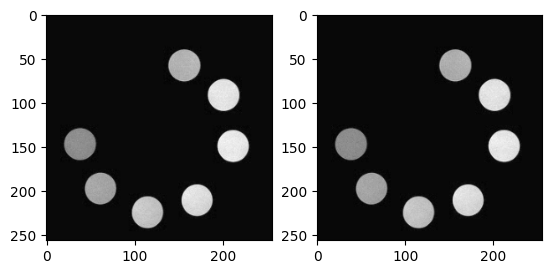

In [10]:
train_dataloader = DataLoader(imt_train, batch_size=8, shuffle=True)
train_images, train_features, train_labels, train_shifted_points = next(iter(train_dataloader))
print(f"Images batch shape: {train_images.dtype, train_images.shape}")
print(f"Feature batch shape: {train_features.dtype, train_features.shape}")
print(f"Labels batch shape: {train_labels.dtype, train_labels.shape}")
print(f"Shifted Points batch size: {train_shifted_points.dtype, len(train_shifted_points)}")
img = train_images[0].squeeze()
label = train_labels[0].squeeze()
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(img, cmap="gray")
f.add_subplot(1,2, 2)
plt.imshow(label, cmap="gray")
plt.show(block=True)


In [11]:
train_dataloader = DataLoader(imt_train, batch_size=16, shuffle=True)
val_dataloader = DataLoader(imt_val, batch_size=16, shuffle=True)
test_dataloader = DataLoader(imt_test, batch_size=16, shuffle=True)

In [12]:
image_samples, feature_samples, label_samples, train_shifted_points = next(iter(test_dataloader))

print(f'Min pixel value: {image_samples.min().item()}')
print(f'Max pixel value: {image_samples.max().item()}')

Min pixel value: 0.00363871268928051
Max pixel value: 0.9627888798713684


In [13]:
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [14]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


In [15]:
class encoder_block2(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=2, dilation=2) # Adding dilation
        
    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.conv2(x)
        return x

In [16]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
        
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [17]:
class decoder_block2(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=1)
        self.conv = conv_block(out_c + out_c, out_c)  # Note: here you need to ensure out_c matches with the skip connection channels.

    def forward(self, inputs, skip):
        x = self.conv1(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [18]:
class build_unet2(nn.Module):
    def __init__(self, n_add_features=4):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block2(1, 16)
        self.e2 = encoder_block2(16, 32)
        self.e3 = encoder_block2(32, 64)
        """ Bottleneck """
        self.b = conv_block(64, 128)
        
        """ Additional features """
        self.fc = nn.Linear(n_add_features, 16*16)  # Fully connected layer to transform the features
        #self.fc = nn.Linear(n_add_features, 256*256)
        """ Decoder """
        self.d1 = decoder_block2(128+n_add_features, 64)
        self.d2 = decoder_block2(64, 32)
        self.d3 = decoder_block2(32, 16)
        """ Regression """
        self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs, additional_features):
        """ Encoder """
        s1 = self.e1(inputs)
        s2 = self.e2(s1)
        s3 = self.e3(s2)
        """ Bottleneck """
        b = self.b(s3)
        """ Additional features """
        additional_features = additional_features.unsqueeze(-1).unsqueeze(-1)
        additional_features = additional_features.expand(-1, -1, b.shape[2], b.shape[3])
        # Concatenate additional features
        b = torch.cat([b, additional_features], dim=1)
        """ Decoder """
        d1 = self.d1(b, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)
        """ Regression """
        outputs = torch.sigmoid(self.outputs(d3))
        return outputs

In [19]:
class build_unet(nn.Module):
    def __init__(self, n_add_features=4):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 32)
        self.e2 = encoder_block(32, 64)
        self.e3 = encoder_block(64, 128)
        self.e4 = encoder_block(128, 256)
        """ Bottleneck """
        self.b = conv_block(256, 512)
        
        """ Additional features """
        self.fc = nn.Linear(n_add_features, 32*32)  # Fully connected layer to transform the features
        #self.fc = nn.Linear(n_add_features, 512*512)  # Fully connected layer to transform the features
        """ Decoder """
        self.d1 = decoder_block(512+n_add_features, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)
        self.d4 = decoder_block(64, 32)
        """ Regression """
        self.outputs = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs, additional_features):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Additional features """
        additional_features = self.fc(additional_features)
        additional_features = additional_features.view(additional_features.shape[0], -1, b.shape[2], b.shape[3])
        # Concatenate additional features
        b = torch.cat([b, additional_features], dim=1)
        
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        """ Regression """
        outputs = torch.sigmoid(self.outputs(d4))
        return outputs

In [20]:
gc.collect()

torch.cuda.empty_cache()

num_epochs=50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet()
model = model.to(device)

mse_loss = MSELoss()
ssim_loss = SSIM(data_range=1.0) 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
if TRAINING==True:
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (input_images_train, input_features_train, target_images_train, shifted_points_val) in enumerate(train_dataloader):
            # For GPU training
            input_images_train = input_images_train.to(device)
            input_features_train = input_features_train.to(device)
            target_images_train = target_images_train.to(device)
    
            output_images_train = model(input_images_train, input_features_train)
    
            mse_train = mse_loss(output_images_train, target_images_train)
            #ssim = ssim_loss(output_images, target_images)
            #ssim = 1 - ssim
            #loss = mse + ssim
            loss_train = mse_train
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
    
        # Validation loop
        model.eval()
        with torch.no_grad():
            loss_val = 0
            for i, (input_images_val, input_features_val, target_images_val, shifted_points_val) in enumerate(val_dataloader):
                input_images_val = input_images_val.to(device)
                additional_input_features_val = input_features_val.to(device)
                target_images_val = target_images_val.to(device)
                
                output_images_val = model(input_images_val, additional_input_features_val)
                mse_val = mse_loss(output_images_val, target_images_val)
                #ssim = ssim_loss(output_images, target_images)
                #ssim = 1 - ssim
                #loss = mse + ssim
                loss = mse_val
                loss_val += loss.item()
    
            loss_val = loss_val / len(val_dataloader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_train.item()}, Validation Loss: {loss_val}")
else:
    print("no training switched on")

no training switched on


In [21]:
if TRAINING==True:
    model.eval() 
    correct = 0
    total = 0 
    test_losses = []
    with torch.no_grad():
        test_loss = 0
        for batch_idx, (input_images_test, input_features_test, target_images_test, shifted_points_test) in enumerate(test_dataloader):
            input_images_test = input_images_test.to(device)
            input_features_test = input_features_test.to(device)
            target_images_test = target_images_test.to(device)
    
            output_images_test = model(input_images_test, input_features_test)
    
            mse = mse_loss(output_images_test, target_images_test)

            loss = mse
            test_loss += loss.item()
            
        print(f"MSE: {test_loss}")
else:
    print("no training switched on")

no training switched on


In [49]:
if TRAINING==True:
    torch.save(model.state_dict(), NEW_MODEL)
else:
    model = build_unet()
    model.load_state_dict(torch.load("imt_model_4.pt"))
    model = model.to(device)

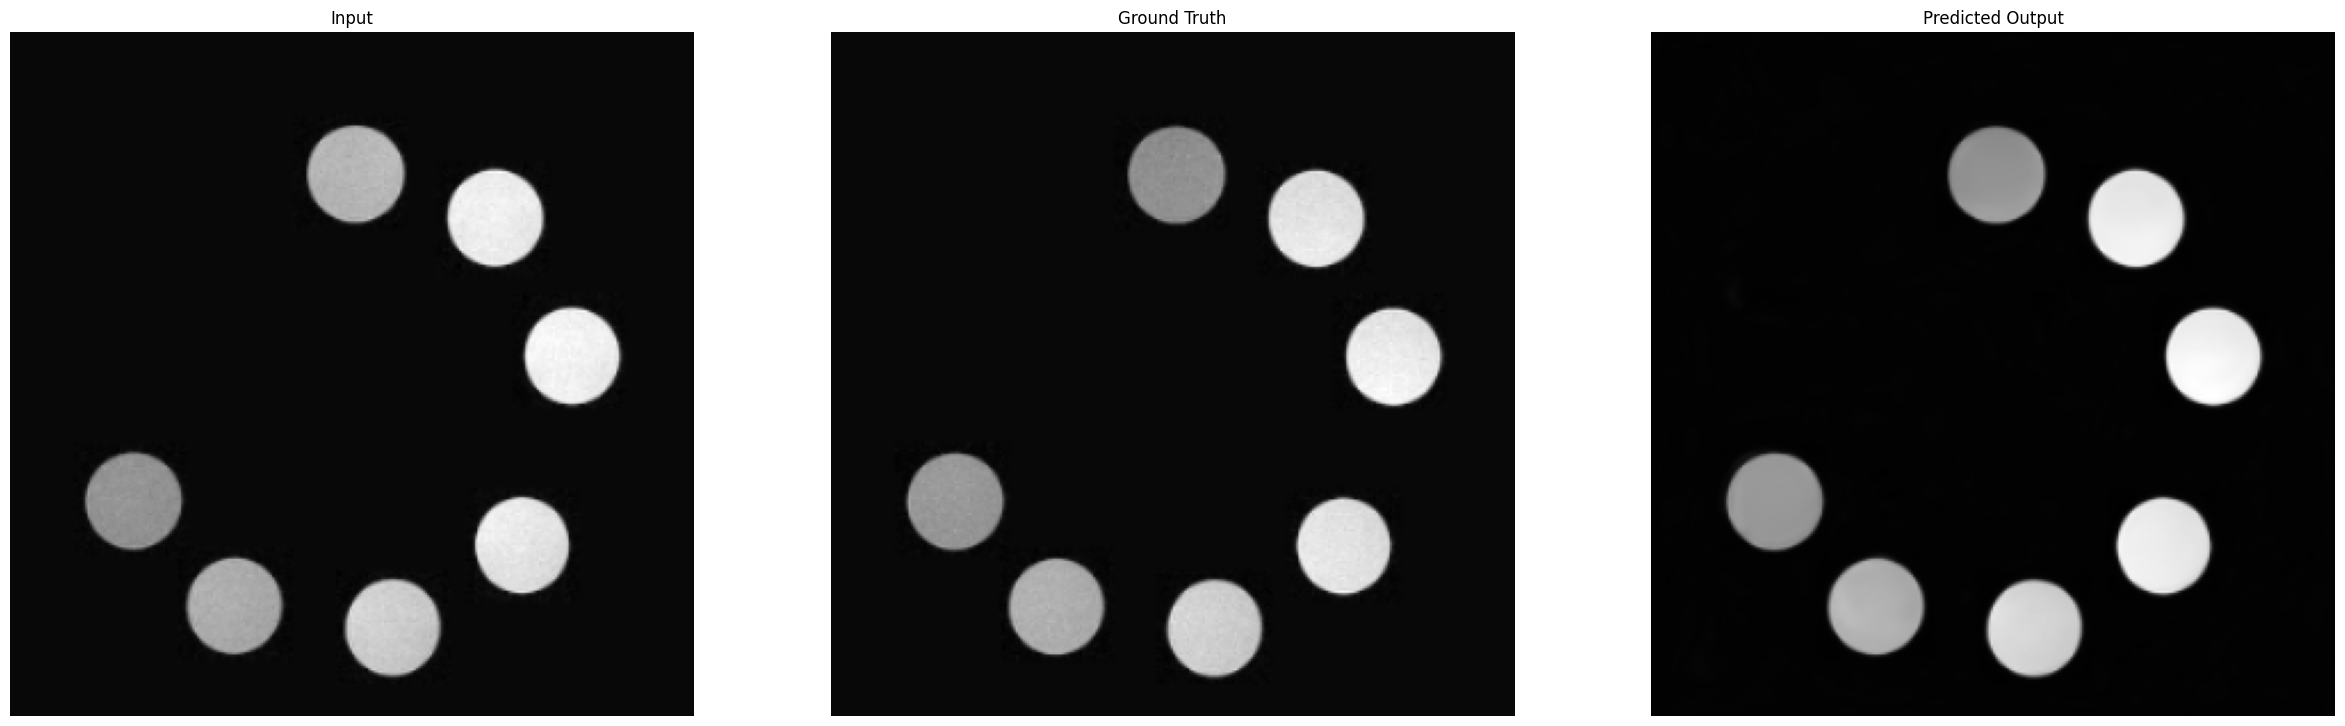

tensor([  8., 200.,  25., 500.], device='cuda:0')


In [68]:
image_check, additional_features_check, target_image_check, shifted_points_check = next(iter(test_dataloader))

image_check = image_check.to(device)
additional_features_check = additional_features_check.to(device)

model.eval()

with torch.no_grad():
    output_check = model(image_check, additional_features_check)

output_np = output_check.cpu().numpy()[0]

input = image_check.cpu().numpy()[0]
ground_truth = target_image_check.cpu().numpy()[0]

fig, axs = plt.subplots(1, 3, figsize=(30, 30))

original_scale = (300, 300)

input=cv2.resize(input[0], original_scale)
axs[0].imshow(input, cmap='gray')
axs[0].set_title('Input')

ground_truth=cv2.resize(ground_truth[0], original_scale)
axs[1].imshow(ground_truth, cmap='gray')
axs[1].set_title('Ground Truth')

output_np=cv2.resize(output_np[0], original_scale)
axs[2].imshow(output_np, cmap='gray')
axs[2].set_title('Predicted Output')
for ax in axs:
    ax.axis('off')

plt.imsave('input_imt.png', input, cmap='gray')
plt.imsave('predicted_imt.png', output_np, cmap='gray')
plt.imsave('ground_truth_imt.png', ground_truth, cmap='gray')
plt.show()
print(additional_features_check[0])

In [24]:
def mse(array1, array2):
    diff = array1 - array2
    squared_diff = np.square(diff)
    mse = np.mean(squared_diff)
    return mse

Mean pixel intensity for sample 1 in ground truth image:  0.32323647
Mean pixel intensity for sample 1 in ground predicted output image:  0.319003
Mean pixel intensity for sample 2 in ground truth image:  0.36085448
Mean pixel intensity for sample 2 in ground predicted output image:  0.35811839
Mean pixel intensity for sample 3 in ground truth image:  0.42371547
Mean pixel intensity for sample 3 in ground predicted output image:  0.42039073
Mean pixel intensity for sample 4 in ground truth image:  0.4586464
Mean pixel intensity for sample 4 in ground predicted output image:  0.45614287
Mean pixel intensity for sample 5 in ground truth image:  0.48605528
Mean pixel intensity for sample 5 in ground predicted output image:  0.4832294
Mean pixel intensity for sample 6 in ground truth image:  0.4724319
Mean pixel intensity for sample 6 in ground predicted output image:  0.4733586
Mean pixel intensity for sample 7 in ground truth image:  0.31125396
Mean pixel intensity for sample 7 in ground

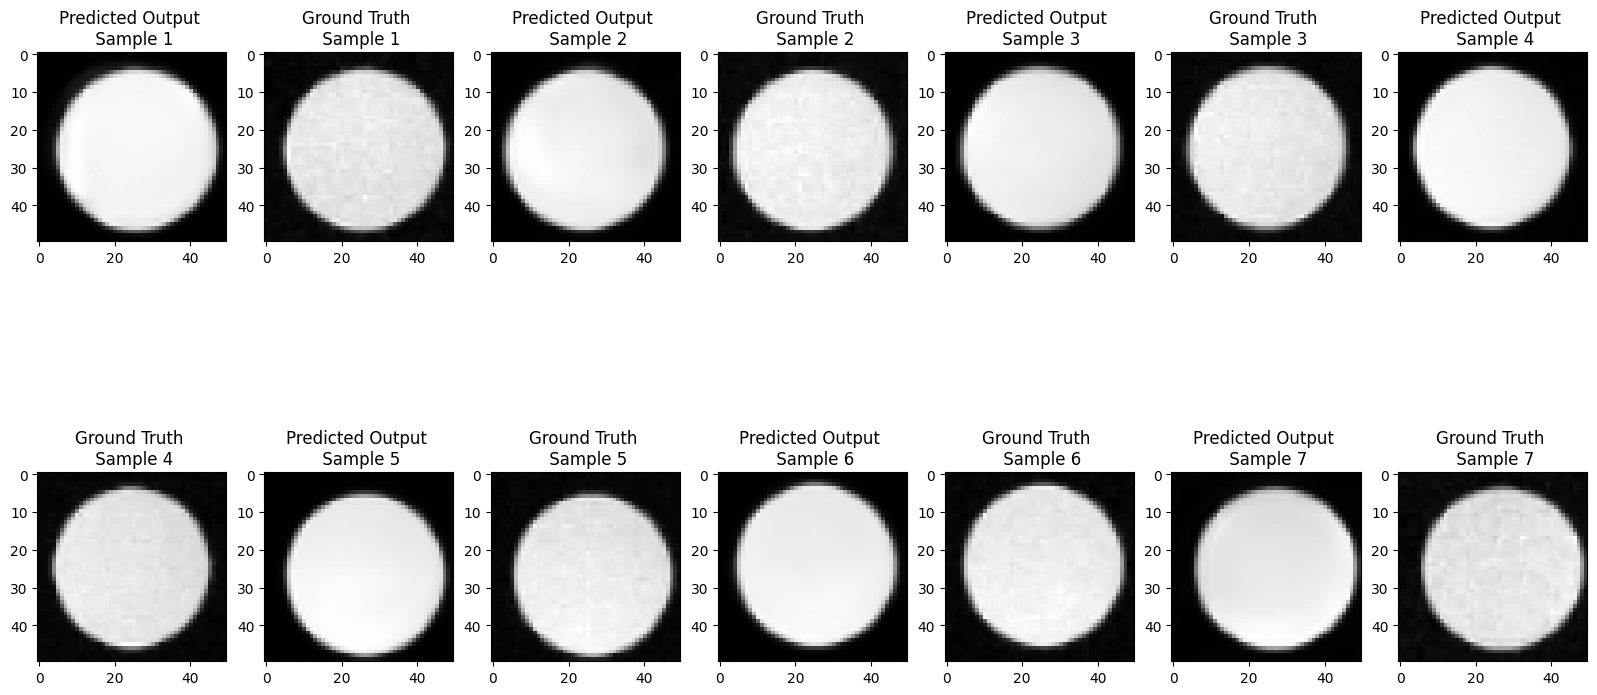

In [69]:
sample1_output_np = output_np[shifted_points_check[0][0][0]:shifted_points_check[0][0][0]+50, shifted_points_check[0][0][1]:shifted_points_check[0][0][1]+50]
sample2_output_np = output_np[shifted_points_check[0][1][0]:shifted_points_check[0][1][0]+50, shifted_points_check[0][1][1]:shifted_points_check[0][1][1]+50]
sample3_output_np = output_np[shifted_points_check[0][2][0]:shifted_points_check[0][2][0]+50, shifted_points_check[0][2][1]:shifted_points_check[0][2][1]+50]
sample4_output_np = output_np[shifted_points_check[0][3][0]:shifted_points_check[0][3][0]+50, shifted_points_check[0][3][1]:shifted_points_check[0][3][1]+50]
sample5_output_np = output_np[shifted_points_check[0][4][0]:shifted_points_check[0][4][0]+50, shifted_points_check[0][4][1]:shifted_points_check[0][4][1]+50]
sample6_output_np = output_np[shifted_points_check[0][5][0]:shifted_points_check[0][5][0]+50, shifted_points_check[0][5][1]:shifted_points_check[0][5][1]+50]
sample7_output_np = output_np[shifted_points_check[0][6][0]:shifted_points_check[0][6][0]+50, shifted_points_check[0][6][1]:shifted_points_check[0][6][1]+50]

sample1_ground_truth = ground_truth[shifted_points_check[0][0][0]:shifted_points_check[0][0][0]+50, shifted_points_check[0][0][1]:shifted_points_check[0][0][1]+50]
sample2_ground_truth = ground_truth[shifted_points_check[0][1][0]:shifted_points_check[0][1][0]+50, shifted_points_check[0][1][1]:shifted_points_check[0][1][1]+50]
sample3_ground_truth = ground_truth[shifted_points_check[0][2][0]:shifted_points_check[0][2][0]+50, shifted_points_check[0][2][1]:shifted_points_check[0][2][1]+50]
sample4_ground_truth = ground_truth[shifted_points_check[0][3][0]:shifted_points_check[0][3][0]+50, shifted_points_check[0][3][1]:shifted_points_check[0][3][1]+50]
sample5_ground_truth = ground_truth[shifted_points_check[0][4][0]:shifted_points_check[0][4][0]+50, shifted_points_check[0][4][1]:shifted_points_check[0][4][1]+50]
sample6_ground_truth = ground_truth[shifted_points_check[0][5][0]:shifted_points_check[0][5][0]+50, shifted_points_check[0][5][1]:shifted_points_check[0][5][1]+50]
sample7_ground_truth = ground_truth[shifted_points_check[0][6][0]:shifted_points_check[0][6][0]+50, shifted_points_check[0][6][1]:shifted_points_check[0][6][1]+50]

print("Mean pixel intensity for sample 1 in ground truth image: ", np.mean(sample1_ground_truth))
print("Mean pixel intensity for sample 1 in ground predicted output image: ", np.mean(sample1_output_np))

print("Mean pixel intensity for sample 2 in ground truth image: ", np.mean(sample2_ground_truth))
print("Mean pixel intensity for sample 2 in ground predicted output image: ", np.mean(sample2_output_np))

print("Mean pixel intensity for sample 3 in ground truth image: ", np.mean(sample3_ground_truth))
print("Mean pixel intensity for sample 3 in ground predicted output image: ", np.mean(sample3_output_np))

print("Mean pixel intensity for sample 4 in ground truth image: ", np.mean(sample4_ground_truth))
print("Mean pixel intensity for sample 4 in ground predicted output image: ", np.mean(sample4_output_np))

print("Mean pixel intensity for sample 5 in ground truth image: ", np.mean(sample5_ground_truth))
print("Mean pixel intensity for sample 5 in ground predicted output image: ", np.mean(sample5_output_np))

print("Mean pixel intensity for sample 6 in ground truth image: ", np.mean(sample6_ground_truth))
print("Mean pixel intensity for sample 6 in ground predicted output image: ", np.mean(sample6_output_np))

print("Mean pixel intensity for sample 7 in ground truth image: ", np.mean(sample7_ground_truth))
print("Mean pixel intensity for sample 7 in ground predicted output image: ", np.mean(sample7_output_np))

fig, axs = plt.subplots(2, 7, figsize=(20, 10))

axs[0][0].imshow(sample1_output_np, cmap='gray')
axs[0][0].set_title('Predicted Output \n Sample 1')

axs[0][1].imshow(sample1_ground_truth, cmap='gray')
axs[0][1].set_title('Ground Truth \n Sample 1')

axs[0][2].imshow(sample2_output_np, cmap='gray')
axs[0][2].set_title('Predicted Output \n Sample 2')

axs[0][3].imshow(sample2_ground_truth, cmap='gray')
axs[0][3].set_title('Ground Truth \n Sample 2')

axs[0][4].imshow(sample3_output_np, cmap='gray')
axs[0][4].set_title('Predicted Output \n Sample 3')

axs[0][5].imshow(sample3_ground_truth, cmap='gray')
axs[0][5].set_title('Ground Truth \n Sample 3')

axs[0][6].imshow(sample4_output_np, cmap='gray')
axs[0][6].set_title('Predicted Output \n Sample 4')

axs[1][0].imshow(sample4_ground_truth, cmap='gray')
axs[1][0].set_title('Ground Truth \n Sample 4')

axs[1][1].imshow(sample5_output_np, cmap='gray')
axs[1][1].set_title('Predicted Output \n Sample 5')

axs[1][2].imshow(sample5_ground_truth, cmap='gray')
axs[1][2].set_title('Ground Truth \n Sample 5')

axs[1][3].imshow(sample6_output_np, cmap='gray')
axs[1][3].set_title('Predicted Output \n Sample 6')

axs[1][4].imshow(sample6_ground_truth, cmap='gray')
axs[1][4].set_title('Ground Truth \n Sample 6')

axs[1][5].imshow(sample7_output_np, cmap='gray')
axs[1][5].set_title('Predicted Output \n Sample 7')

axs[1][6].imshow(sample7_ground_truth, cmap='gray')
axs[1][6].set_title('Ground Truth \n Sample 7')

fig.savefig('each_sample.png')